# Use AutoAI and multiple data to predict sale quantity with `ibm-watson-machine-learning`

This notebook contains the steps and code to demonstrate support of AutoAI experiments for multi files data sets in Watson Machine Learning service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines, refining pipelines, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.7.


## Learning goals

The learning goals of this notebook are:

-  Define Watson Machine Learning experiment for multiple data sets. 
-  Work with experiments to train AutoAI models.
-  Compare trained models quality and select the best one for further deployment.
-  Batch deployment and score the trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Multiple data sets](#obm)
3.	[Optimizer definition](#definition)
4.	[Experiment Run](#run)
5.	[Pipelines comparison and testing](#comparison)
6.	[Deploy and Score](#scoring)
7.  [Clean up](#cleanup)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `password`.

In [1]:
username = 'PASTE YOUR USERNAME HERE'
password = 'PASTE YOUR PASSWORD HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
wml_credentials = {
    "username": username,
    "password": password,
    "url": url,
    "instance_id": 'openshift',
    "version": '3.5'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="https://ibm.github.io/watson-machine-learning-sdk//" target="_blank" rel="noopener no referrer">here</a>.

In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd3.5/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [8]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [11]:
client.set.default_space(space_id)

'SUCCESS'

<a id="obm"></a>
## 2. Multiple data sets

### Training data sets

Download training data from git repository and create data assets. This example uses the [Go sale dataset](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/dcf7b09bd340e6ff9a2d1869631f3753).

In [12]:
import os, wget, zipfile

filenames = ['go_1k.csv', 'go_daily_sales.csv', 'go_methods.csv', 'go_products.csv', 'go_retailers.csv']
base_url = 'https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd3.5/data/go_sales/'

for filename in filenames:
    if not os.path.isfile(filename): wget.download(base_url + filename)
        
assets_details = [client.data_assets.create(name=filename, file_path=filename) for filename in filenames]

Creating data asset...
SUCCESS
Creating data asset...
SUCCESS
Creating data asset...
SUCCESS
Creating data asset...
SUCCESS
Creating data asset...
SUCCESS


### Training data connection
The code in next cell defines connections to created assets.

**Note:** `data_join_node_name` (any string) will be used to define data joins in next step.

In [13]:
from ibm_watson_machine_learning.helpers import DataConnection, AssetLocation

data_connections = [
    DataConnection(data_join_node_name=filename,
                   location=AssetLocation(asset_id=client.data_assets.get_id(asset))) 
    for filename, asset in zip(filenames, assets_details)]

### DataJoin graph definition
The code in next cell defines the join graph. Join graph describes how data sets whould be join together.
The dot syntax is used. First, graph nodes are defined using `data_join_node_names`.
Next, edges between nodes with join columns names (`from_column`, `to_column`).


**Note:** `data_join_graph.visualize()` is used to inspect data join graph definition and correct if needed.

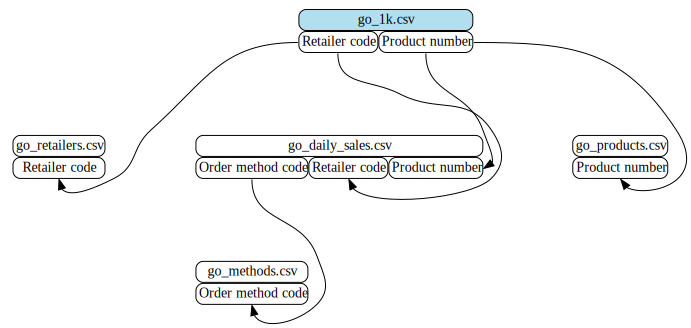

In [14]:
from ibm_watson_machine_learning.preprocessing import DataJoinGraph

data_join_graph = DataJoinGraph()

for filename in filenames: 
    data_join_graph.node(name=filename)

data_join_graph.edge(from_node="go_1k.csv", to_node="go_daily_sales.csv", 
                     from_column=["Retailer code", "Product number"], to_column=["Retailer code", "Product number"])
data_join_graph.edge(from_node="go_daily_sales.csv", to_node="go_methods.csv",
                     from_column=["Order method code"], to_column=["Order method code"])
data_join_graph.edge(from_node="go_1k.csv", to_node="go_products.csv",
                     from_column=["Product number"], to_column=["Product number"])
data_join_graph.edge(from_node="go_1k.csv", to_node="go_retailers.csv",
                     from_column=["Retailer code"], to_column=["Retailer code"])

data_join_graph.visualize()

Data join graph contains the information how multi source data should be joined as part of preprocessing step in AutoAI experiment.

<a id="definition"></a>
## 3. Optimizer definition

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [15]:
from ibm_watson_machine_learning.experiment import AutoAI

experiment = AutoAI(wml_credentials, space_id=space_id)


pipeline_optimizer = experiment.optimizer(
            name="Go sales quantity",
            prediction_type=AutoAI.PredictionType.REGRESSION,
            prediction_column='Quantity',
            scoring=AutoAI.Metrics.R2_SCORE,
            max_number_of_estimators=1,
            data_join_graph=data_join_graph,
            test_size=0.5
        )

Configuration parameters can be retrieved via `pipeline_optimizer.get_params()`.

<a id="run"></a>
## 4. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [16]:
fit_details = pipeline_optimizer.fit(training_data_reference=data_connections, background_mode=False)

Training job 731d7eda-03a9-47f3-8b9d-9cdfda8bf1dc completed: 100%|█| 155/155 [06:38<00:00,  2.57s/it


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [17]:
pipeline_optimizer.get_run_status()

'completed'

<a id="comparison"></a>
## 5. Pipelines comparison and inspection

You can list trained pipelines and evaluation metrics information in
the form of a Pandas DataFrame by calling the `summary()` method. You can
use the DataFrame to compare all discovered pipelines and select the one
you like for further testing.

In [18]:
summary = pipeline_optimizer.summary()
summary

,Number of enhancements,Estimator,holdout_explained_variance,holdout_neg_median_absolute_error,holdout_neg_root_mean_squared_log_error,holdout_neg_mean_squared_error,training_explained_variance,training_r2_(optimized),training_neg_median_absolute_error,training_neg_mean_squared_error,training_neg_root_mean_squared_error,holdout_r2,training_neg_mean_absolute_error,holdout_neg_root_mean_squared_error,holdout_neg_mean_absolute_error,holdout_neg_mean_squared_log_error
Pipeline Name,,,,,,,,,,,,,,,,
Pipeline_3,2,GradientBoostingRegressorEstimator,0.634112,-16.297995,-0.632190,-59783.997706,0.826525,0.823809,-16.683816,-10076.471974,-98.967871,0.630773,-44.719943,-244.507664,-62.856191,-0.399665
Pipeline_4,3,GradientBoostingRegressorEstimator,0.634112,-16.297995,-0.632190,-59783.997706,0.826525,0.823809,-16.683816,-10076.471974,-98.967871,0.630773,-44.719943,-244.507664,-62.856191,-0.399665
Pipeline_2,1,GradientBoostingRegressorEstimator,0.629214,-15.990857,-0.646851,-60624.287414,0.807357,0.804595,-16.630405,-11231.216118,-104.247996,0.625584,-46.258516,-246.219998,-65.683144,-0.418416
Pipeline_1,0,GradientBoostingRegressorEstimator,0.545527,-17.088901,-0.686084,-73669.480190,0.730573,0.729194,-18.238467,-15171.469884,-121.415438,0.545016,-50.339018,-271.421223,-72.971946,-0.470712


You can visualize the scoring metric calculated on a holdout data set.

<AxesSubplot:xlabel='Pipeline Name'>

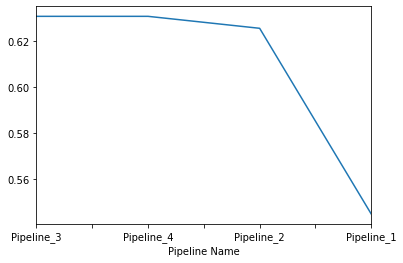

In [19]:
import pandas as pd
pd.options.plotting.backend = "plotly"

summary.holdout_r2.plot()

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [20]:
best_pipeline = pipeline_optimizer.get_pipeline()

Unknown transformation:  ItemsetCOR
Unknown transformation:  ItemsetCOR
Unknown transformation:  ItemsetCOR
Unknown transformation:  ItemsetCOR
Unknown transformation:  ItemsetCOR
Unknown transformation:  ItemsetCOR


Check features importance for selected pipeline. You can see new features created during data joining and feature engineering phases.

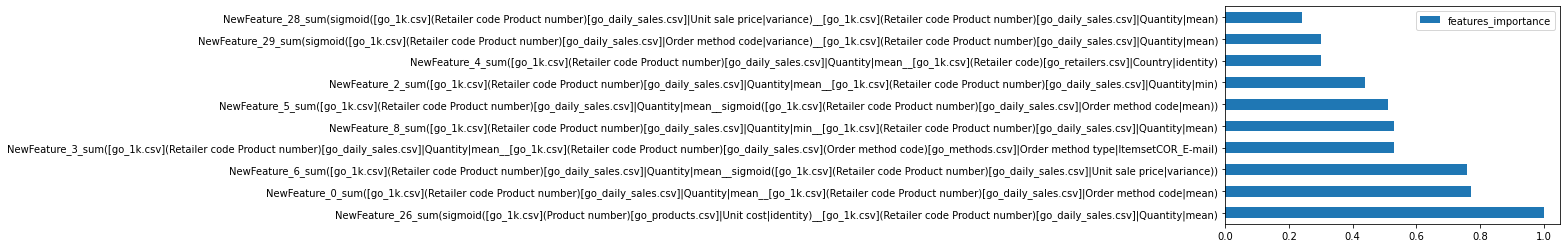

In [28]:
pipeline_optimizer.get_pipeline_details()['features_importance'].head(10).plot.barh();

### Visualize pipeline

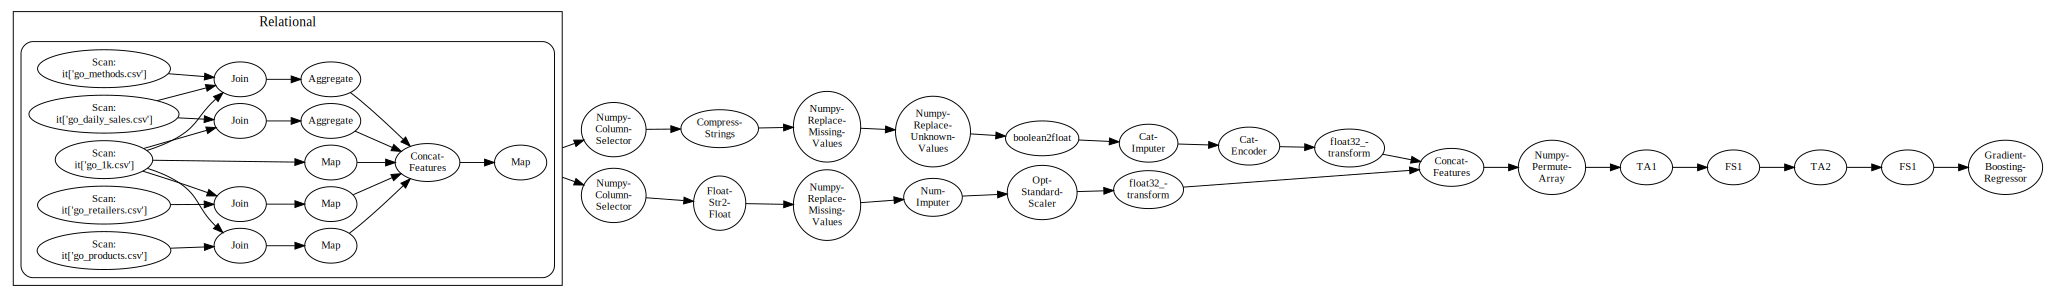

In [22]:
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.

### Pipeline source code

In [29]:
best_pipeline.pretty_print(ipython_display=True, astype='sklearn')

```python
from lale.lib.lale import Relational
from lale.lib.lale import Scan
from lale.expressions import it
from lale.lib.lale import Map
from lale.lib.lale import Join
from lale.lib.lale import Aggregate
from lale.expressions import mean
from lale.expressions import min
from lale.expressions import sum
from lale.expressions import max
from lale.expressions import variance
from sklearn.pipeline import make_pipeline
from lale.expressions import distinct_count
from lale.expressions import count
from lale.lib.lale import ConcatFeatures
from lale.expressions import string_indexer
from lale.operators import make_pipeline_graph
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TA1
import autoai_libs.cognito.transforms.textras_methods
import autoai_libs.utils.fc_methods
from autoai_libs.cognito.transforms.transform_utils import FS1
from autoai_libs.cognito.transforms.transform_utils import TA2
from sklearn.ensemble import GradientBoostingRegressor

scan = Scan(table=it["go_1k.csv"])
map = Map(
    columns={
        "[go_1k.csv]|Product number|identity": it["Product number"],
        "[go_1k.csv]|Retailer code|identity": it["Retailer code"],
        "Quantity": it["Quantity"],
        "prefix_0_id": it["prefix_0_id"],
    },
    remainder="drop",
)
scan_0 = Scan(table=it["go_daily_sales.csv"])
join = Join(
    pred=[
        (
            it["go_1k.csv"]["Retailer code"]
            == it["go_daily_sales.csv"]["Retailer code"]
        ),
        (
            it["go_1k.csv"]["Product number"]
            == it["go_daily_sales.csv"]["Product number"]
        ),
    ],
    join_limit=50.0,
)
aggregate = Aggregate(
    columns={
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|mean": mean(
            it["Unit price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|mean": mean(
            it["Quantity"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|sum": sum(
            it["Unit price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|sum": sum(
            it["Quantity"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|max": max(
            it["Quantity"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|min": min(
            it["Unit price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|variance": variance(
            it["Quantity"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|variance": variance(
            it["Order method code"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|mean": mean(
            it["Unit sale price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|max": max(
            it["Unit price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|max": max(
            it["Unit sale price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|sum": sum(
            it["Unit sale price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|variance": variance(
            it["Unit price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|min": min(
            it["Order method code"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|sum": sum(
            it["Order method code"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|variance": variance(
            it["Unit sale price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|min": min(
            it["Quantity"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|min": min(
            it["Unit sale price"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|mean": mean(
            it["Order method code"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|max": max(
            it["Order method code"]
        ),
    },
    group_by=it["row_id"],
)
pipeline_4 = make_pipeline(join, aggregate)
scan_1 = Scan(table=it["go_retailers.csv"])
join_0 = Join(
    pred=[
        (
            it["go_1k.csv"]["Retailer code"]
            == it["go_retailers.csv"]["Retailer code"]
        )
    ]
)
map_0 = Map(
    columns={
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Retailer name|identity": it[
            "Retailer name"
        ],
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Country|identity": it[
            "Country"
        ],
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Type|identity": it[
            "Type"
        ],
    },
    remainder="drop",
)
pipeline_5 = make_pipeline(join_0, map_0)
scan_2 = Scan(table=it["go_products.csv"])
join_1 = Join(
    pred=[
        (
            it["go_1k.csv"]["Product number"]
            == it["go_products.csv"]["Product number"]
        )
    ]
)
map_1 = Map(
    columns={
        "[go_1k.csv](Product number)[go_products.csv]|Product type|identity": it[
            "Product type"
        ],
        "[go_1k.csv](Product number)[go_products.csv]|Product brand|identity": it[
            "Product brand"
        ],
        "[go_1k.csv](Product number)[go_products.csv]|Unit cost|identity": it[
            "Unit cost"
        ],
        "[go_1k.csv](Product number)[go_products.csv]|Unit price|identity": it[
            "Unit price"
        ],
        "[go_1k.csv](Product number)[go_products.csv]|Product line|identity": it[
            "Product line"
        ],
        "[go_1k.csv](Product number)[go_products.csv]|Product|identity": it[
            "Product"
        ],
        "[go_1k.csv](Product number)[go_products.csv]|Product color|identity": it[
            "Product color"
        ],
    },
    remainder="drop",
)
pipeline_6 = make_pipeline(join_1, map_1)
scan_3 = Scan(table=it["go_methods.csv"])
join_2 = Join(
    pred=[
        (
            it["go_1k.csv"]["Retailer code"]
            == it["go_daily_sales.csv"]["Retailer code"]
        ),
        (
            it["go_1k.csv"]["Product number"]
            == it["go_daily_sales.csv"]["Product number"]
        ),
        (
            it["go_daily_sales.csv"]["Order method code"]
            == it["go_methods.csv"]["Order method code"]
        ),
    ],
    join_limit=50.0,
)
aggregate_0 = Aggregate(
    columns={
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|distinct_count": distinct_count(
            it["Order method type"]
        ),
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|count": count(
            it["Order method type"]
        ),
    },
    group_by=it["row_id"],
)
pipeline_7 = make_pipeline(join_2, aggregate_0)
map_2 = Map(
    columns=[
        string_indexer(
            it[
                "[go_1k.csv](Retailer code)[go_retailers.csv]|Retailer name|identity"
            ]
        ),
        string_indexer(
            it["[go_1k.csv](Retailer code)[go_retailers.csv]|Type|identity"]
        ),
        string_indexer(
            it[
                "[go_1k.csv](Retailer code)[go_retailers.csv]|Country|identity"
            ]
        ),
        string_indexer(
            it[
                "[go_1k.csv](Product number)[go_products.csv]|Product line|identity"
            ]
        ),
        string_indexer(
            it[
                "[go_1k.csv](Product number)[go_products.csv]|Product brand|identity"
            ]
        ),
        string_indexer(
            it[
                "[go_1k.csv](Product number)[go_products.csv]|Product color|identity"
            ]
        ),
        string_indexer(
            it[
                "[go_1k.csv](Product number)[go_products.csv]|Product|identity"
            ]
        ),
        string_indexer(
            it[
                "[go_1k.csv](Product number)[go_products.csv]|Product type|identity"
            ]
        ),
    ]
)
pipeline_8 = make_pipeline(ConcatFeatures(), map_2)
relational = Relational(
    operator=make_pipeline_graph(
        steps=[
            scan,
            map,
            scan_0,
            pipeline_4,
            scan_1,
            pipeline_5,
            scan_2,
            pipeline_6,
            scan_3,
            pipeline_7,
            pipeline_8,
        ],
        edges=[
            (scan, map),
            (scan, pipeline_4),
            (scan, pipeline_5),
            (scan, pipeline_6),
            (scan, pipeline_7),
            (map, pipeline_8),
            (scan_0, pipeline_4),
            (scan_0, pipeline_7),
            (pipeline_4, pipeline_8),
            (scan_1, pipeline_5),
            (pipeline_5, pipeline_8),
            (scan_2, pipeline_6),
            (pipeline_6, pipeline_8),
            (scan_3, pipeline_7),
            (pipeline_7, pipeline_8),
        ],
    )
)
numpy_column_selector_0 = NumpyColumnSelector(
    columns=[0, 3, 9, 11, 18, 23, 24, 27, 28, 33, 34, 35, 36, 37, 39]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num", "float_int_num",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[
        [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],
    ],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=100001
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=100001,
    filling_values_list=[
        100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
        100001, 100001, 100001, 100001, 100001, 100001,
    ],
    known_values_list=[
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
        [1.0, 2.0, 3.0, 4.0, 5.0],
        [
            0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 11.0, 13.0, 14.0,
            15.0, 18.0, 23.0,
        ],
        [2.0, 4.0, 5.0, 6.0, 7.0],
        [
            17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0,
            28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0,
            39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0,
            50.0,
        ],
        [0.0, 1.0, 2.0, 3.0, 4.0, 6.0],
        [1.0, 2.0, 3.0, 4.0, 5.0],
        [
            0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0,
            15.0, 16.0, 17.0, 18.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0,
            43.0, 50.0,
        ],
        [
            0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
            13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 24.0,
            26.0, 27.0, 34.0, 36.0, 37.0, 39.0, 48.0,
        ],
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
        [
            0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
            13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0,
        ],
        [0.0, 1.0, 2.0, 3.0, 4.0],
        [
            0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
            13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0,
        ],
        [
            0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
            13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0,
        ],
        [
            0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
            13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0,
        ],
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    strategy="most_frequent",
    missing_values=100001,
    sklearn_version_family="23",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="23",
)
pipeline_1 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(
    columns=[
        1, 2, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26,
        29, 30, 31, 32, 38,
    ]
)
float_str2_float = FloatStr2Float(
    dtypes_list=[
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_num", "float_num", "float_num", "float_int_num", "float_num",
        "float_int_num", "float_num", "float_int_num", "float_int_num",
        "float_num", "float_num", "float_num", "float_num", "float_num",
        "float_int_num", "float_num", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num",
    ],
    missing_values_reference_list=[],
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
num_imputer = NumImputer(strategy="median", missing_values=float("nan"))
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_2 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_1, pipeline_2)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        0, 3, 9, 11, 18, 23, 24, 27, 28, 33, 34, 35, 36, 37, 39, 1, 2, 4, 5, 6,
        7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 29, 30, 31,
        32, 38,
    ],
)
ta1 = TA1(
    fun=autoai_libs.cognito.transforms.textras_methods.sigmoid,
    name="sigmoid",
    datatypes=["numeric"],
    feat_constraints=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Mail",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|sum",
        "[go_1k.csv](Product number)[go_products.csv]|Unit cost|identity",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Sales_visit",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|sum",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|max",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|sum",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|variance",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|sum",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|variance",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Web",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|count",
        "[go_1k.csv](Product number)[go_products.csv]|Unit price|identity",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|max",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|variance",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|max",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Special",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|distinct_count",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|variance",
        "[go_1k.csv]|Retailer code|identity",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_E-mail",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Telephone",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|max",
        "[go_1k.csv]|Product number|identity",
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Retailer name|identity",
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Type|identity",
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Country|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product line|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product brand|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product color|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product type|identity",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_0 = FS1(
    cols_ids_must_keep=range(0, 40),
    additional_col_count_to_keep=30,
    ptype="regression",
)
ta2 = TA2(
    fun=np.add,
    name="sum",
    datatypes1=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical],
    datatypes2=[
        "intc", "intp", "int_", "uint8", "uint16", "uint32", "uint64", "int8",
        "int16", "int32", "int64", "short", "long", "longlong", "float16",
        "float32", "float64",
    ],
    feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical],
    col_names=[
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Mail",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|sum",
        "[go_1k.csv](Product number)[go_products.csv]|Unit cost|identity",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Sales_visit",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|sum",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|max",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|sum",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|variance",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|sum",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|variance",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Web",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|min",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|count",
        "[go_1k.csv](Product number)[go_products.csv]|Unit price|identity",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|max",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|variance",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|max",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Special",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|distinct_count",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|variance",
        "[go_1k.csv]|Retailer code|identity",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_E-mail",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Telephone",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|mean",
        "[go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|max",
        "[go_1k.csv]|Product number|identity",
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Retailer name|identity",
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Type|identity",
        "[go_1k.csv](Retailer code)[go_retailers.csv]|Country|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product line|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product brand|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product color|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product|identity",
        "[go_1k.csv](Product number)[go_products.csv]|Product type|identity",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|min)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|mean)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|min)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|mean)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|sum)",
        "sigmoid([go_1k.csv](Product number)[go_products.csv]|Unit cost|identity)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|mean)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|sum)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|sum)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|variance)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|sum)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|variance)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Web)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|min)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|count)",
        "sigmoid([go_1k.csv](Product number)[go_products.csv]|Unit price|identity)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit price|max)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|variance)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|max)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Order method code|variance)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_E-mail)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv](Order method code)[go_methods.csv]|Order method type|ItemsetCOR_Telephone)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Unit sale price|mean)",
        "sigmoid([go_1k.csv](Retailer code Product number)[go_daily_sales.csv]|Quantity|max)",
        "sigmoid([go_1k.csv](Retailer code)[go_retailers.csv]|Retailer name|identity)",
        "sigmoid([go_1k.csv](Retailer code)[go_retailers.csv]|Country|identity)",
        "sigmoid([go_1k.csv](Product number)[go_products.csv]|Product brand|identity)",
        "sigmoid([go_1k.csv](Product number)[go_products.csv]|Product color|identity)",
        "sigmoid([go_1k.csv](Product number)[go_products.csv]|Product|identity)",
        "sigmoid([go_1k.csv](Product number)[go_products.csv]|Product type|identity)",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_1 = FS1(
    cols_ids_must_keep=range(0, 40),
    additional_col_count_to_keep=30,
    ptype="regression",
)
gradient_boosting_regressor = GradientBoostingRegressor(
    alpha=0.5155667001476331,
    loss="huber",
    max_depth=4,
    max_features=0.33761641026359407,
    min_samples_leaf=0.010685492408650153,
    min_samples_split=0.49922469327197383,
    n_estimators=69,
    presort="auto",
    random_state=33,
)
pipeline = make_pipeline(
    relational,
    union,
    numpy_permute_array,
    ta1,
    fs1_0,
    ta2,
    fs1_1,
    gradient_boosting_regressor,
)
```

### Reading joined training data
You can read joined data using code in below cell.

In [33]:
train_df = pipeline_optimizer.get_preprocessed_data_connection().read()

train_X = train_df.drop(['Quantity'], axis=1).values
train_y = train_df.Quantity.values

### Test pipeline model locally

In [34]:
predicted_y = best_pipeline.predict(train_X)
predicted_y[:5]

array([41.99490703, 32.14409008, 11.71224403, 44.30723781,  6.82148717])

<a id="scoring"></a>
## 6. Deploy and Score

In this section you will learn how to deploy and score pipeline model as batch deployment using WML instance.

In [35]:
pipeline_name = "Pipeline_1"

### Batch deployment creation

In [36]:
from ibm_watson_machine_learning.deployment import Batch

service = Batch(wml_credentials, source_space_id=space_id)

service.create(
    experiment_run_id=pipeline_optimizer.get_run_details()['metadata']['guid'],
    model=pipeline_name, 
    deployment_name="Product Quantity with OBM and KB AutoAI"
    )

Preparing an AutoAI Deployment...
Published model uid: 60269eec-560d-4cec-86f5-0f6cf39fb46f
Deploying model 60269eec-560d-4cec-86f5-0f6cf39fb46f using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '60269eec-560d-4cec-86f5-0f6cf39fb46f' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='6f54697e-688d-459c-8eef-e613bb7cb130'
------------------------------------------------------------------------------------------------




To show all available information about the deployment use the `.get_params()` method:

In [38]:
service.get_params()

{'entity': {'asset': {'id': '60269eec-560d-4cec-86f5-0f6cf39fb46f'},
  'batch': {},
  'custom': {},
  'deployed_asset_type': 'model',
  'hybrid_pipeline_hardware_specs': [{'hardware_spec': {'name': 'M-Spark',
     'num_nodes': 2},
    'node_runtime_id': 'auto_ai.obm'},
   {'hardware_spec': {'name': 'M'}, 'node_runtime_id': 'autoai.kb'}],
  'name': 'Product Quantity with OBM and KB AutoAI',
  'space_id': 'c4c234bf-7e0e-4697-8527-f3d291730dfd',
  'status': {'state': 'ready'}},
 'metadata': {'created_at': '2020-10-30T12:13:29.664Z',
  'id': '6f54697e-688d-459c-8eef-e613bb7cb130',
  'modified_at': '2020-10-30T12:13:29.664Z',
  'name': 'Product Quantity with OBM and KB AutoAI',
  'owner': '1000330999',
  'space_id': 'c4c234bf-7e0e-4697-8527-f3d291730dfd'}}

### Running batch job
You can make scoring request by calling `run_job()` on deployed pipeline. The job will do data join and next call the machine learning pipeline.

**Action**: Define: `scoring_data_reference` that contains connection to data sets (multiple files). In the below example training data is used for simplicity.

In [43]:
scoring_data_reference = data_connections

**Action:** Define `output_data_reference` that will contain predictions calculated for `scoring_data_reference`.

In [58]:
from ibm_watson_machine_learning.helpers.connections import DeploymentOutputAssetLocation

output_filename = "quantity_product_batch_output.csv"

output_data_reference = DataConnection(
    location=DeploymentOutputAssetLocation(name=output_filename))

Run the batch job.

In [50]:
job_details = service.run_job(
    payload=scoring_data_reference,
    output_data_reference=output_data_reference,
    background_mode=False)



##########################################################################

Synchronous scoring for id: '3ebe711e-107b-400d-a344-373cc5056547' started

##########################################################################


queued..
running.............
completed
Scoring job  '3ebe711e-107b-400d-a344-373cc5056547' finished successfully.


### Getting predictions

The code in cell below downloads output csv file and reads it as pandas dataframe.

In [66]:
import pandas as pd

output_asset_id = job_details['entity']['scoring']['output_data_reference']['location']['href'].split('?')[0].replace('/v2/assets/','')
client.data_assets.download(output_asset_id, output_filename)
predictions = pd.read_csv(output_filename)
predictions.head()

Successfully saved data asset content to file: 'quantity_product_batch_output.csv'


,prediction
0,50.312475
1,33.968003
2,13.194966
3,48.202470
4,12.109230


<a id="cleanup"></a>
## 7. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 9. Summary and next steps

 You successfully completed this notebook!.
 
 You learned how to use `ibm-watson-machine-learning` to run AutoAI experiments. 
 
 Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.


Copyright © 2020, 2021, 2022 IBM. This notebook and its source code are released under the terms of the MIT License.